In [1]:
# Cargar las librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

# Cargar la data

In [3]:
# Carga de datos de archivos .csv
url = '/content/drive/MyDrive/Cursos/Coursera/Maestría en Inteligencia Analítica de Datos/202312/Proyecto aplicado en analítica de datos/Proyecto de Grado/datos/SECOP I filtro.txt'
secop1 = pd.read_csv(url, delimiter='|', dtype='str')

# Selecciona las columnas seleccionadas en el preprocesamiento
columnasSeleccionadas = ['UID', #1
                         'Anno Cargue SECOP', #2
                         'Anno Firma Contrato', #3
                         'Nivel Entidad', #4
                         'Orden Entidad', #5
                         'Nombre Entidad', #6
                         'NIT de la Entidad', #7
                         'Código de la Entidad', #8
                         'ID Modalidad', #9
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11
                         'ID Objeto a Contratar', #15
                         'Objeto a Contratar', #16
                         'Detalle del Objeto a Contratar', #17
                         'Municipio de Obtencion', #19
                         'Municipio de Entrega', #20
                         'Numero de Constancia', #23
                         'Numero de Proceso', #24
                         'Numero de Contrato', #25
                         'Cuantia Proceso', #26
                         'ID Grupo', #27
                         'Nombre Grupo', #28
                         'ID Familia', #29
                         'Nombre Familia', #30
                         'ID Clase', #31
                         'Nombre Clase', #32
                         'ID Adjudicacion', #33
                         'Tipo Identifi del Contratista', #34
                         'Identificacion del Contratista', #35
                         'Nom Razon Social Contratista', #36
                         'Dpto y Muni Contratista', #37
                         'Identific Representante Legal', #39
                         'Nombre del Represen Legal', #40
                         'Fecha de Firma del Contrato', #41
                         'Fecha Ini Ejec Contrato', #42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Tiempo Adiciones en Dias', #45
                         'Tiempo Adiciones en Meses', #46
                         'Fecha Fin Ejec Contrato', #47
                         'Cuantia Contrato', #49
                         'Valor Total de Adiciones', #50
                         'Valor Contrato con Adiciones', #51
                         'Objeto del Contrato a la Firma', #52
                         'Proponentes Seleccionados', #53
                         'Calificacion Definitiva', #54
                         'Es PostConflicto', #59
                         'Municipio Entidad', #67
                         'Departamento Entidad', #68
                         'Ultima Actualizacion', #69
                         'Fecha Liquidacion', #70
                         'Cumple Decreto 248', #71
                         'IncluyeBienesDecreto248' #72
                         ]


# Imputa valores NA
secop1['Fecha Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].fillna(secop1['Fecha de Cargue en el SECOP'])
#secop1['Cuantía Contrato'] = secop1['Cuantía Contrato'].fillna(secop1['Cuantía Proceso'])

# Cambia el tipo de las columnas numericas
columnasNumero = ['Cuantia Proceso', #26
                  'Plazo de Ejec del Contrato', #43
                  'Tiempo Adiciones en Dias', #45 ? sobra
                  'Tiempo Adiciones en Meses', #46 ? sobra
                  'Cuantia Contrato', #49
                  'Valor Total de Adiciones', #50 ? sobra
                  'Valor Contrato con Adiciones' #51 ? sobra
                  ]
secop1[columnasNumero] = secop1[columnasNumero].astype('int64')

# Convierte a formato fecha
#secop1['Ultima Actualizacion'] = pd.to_datetime(secop1['Ultima Actualizacion'], format='%d/%m/%Y')
secop1['Fecha Ini Ejec Contrato'] = pd.to_datetime(secop1['Fecha Ini Ejec Contrato'], format='%d/%m/%Y')
# Extrae año y mes
secop1['Anno Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.year
secop1['Mes Ini Ejec Contrato'] = secop1['Fecha Ini Ejec Contrato'].dt.month

# Convierte años de 0 a 4 segun su posicion en cuetrenios desde 2016
secop1['Anno Ini Ejec Contrato'] = (secop1['Anno Ini Ejec Contrato']-2016)%4


# Crea Prorroga y Adicion
#secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'].apply(lambda x: 'Prorrogado' if x != 0 else 'No Prorrogado')
secop1['Prorroga'] = secop1['Tiempo Adiciones en Dias'] + secop1['Tiempo Adiciones en Meses']
secop1['Prorroga'] = secop1['Prorroga'].apply(lambda x: 1 if x != 0 else 0)
#secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 'Adicionado' if x != 0 else 'No Adicionado')
secop1['Adicion'] = secop1['Valor Total de Adiciones'].apply(lambda x: 1 if x != 0 else 0)


# Selecciona las columnas seleccionadas en el feature engineering
columnasSeleccionadas = ['Orden Entidad', #5
                         'Modalidad de Contratacion', #10
                         'Estado del Proceso', #11 adicional
                         #'Nombre Regimen de Contratacion', #14 ? igual que modalidad
                         'Objeto a Contratar', #16
                         'Municipio de Obtencion', #19
                         #'Anno de Cargue en el SECOP', #22 ?
                         #'Mes de Cargue en el SECOP', #22 ?
                         'Cuantia Proceso', #26
                         'Nombre Grupo', #28
                         'Tipo Identifi del Contratista', #34
                         'Dpto y Muni Contratista', #37
                         'Anno Ini Ejec Contrato', #42
                         'Mes Ini Ejec Contrato', # 42
                         'Plazo de Ejec del Contrato', #43
                         'Rango de Ejec del Contrato', #44
                         'Prorroga', #45 y 46
                         'Tiempo Adiciones en Dias', #45 ? perdida de informacion
                         'Tiempo Adiciones en Meses', #46 ? perdida de informacion
                         'Cuantia Contrato', #49
                         'Adicion', #50
                         'Valor Total de Adiciones', #50 ? sobra
                         'Valor Contrato con Adiciones', #51 ? sobra
                         #'Proponentes Seleccionados', #53
                         'Departamento Entidad' #68
                         ]

secop1 = secop1[columnasSeleccionadas]

# Codificar las columnas categoricas
#secop1['Nivel Entidad'] = pd.factorize(secop1['Nivel Entidad'])[0]
secop1['Orden Entidad'] = pd.factorize(secop1['Orden Entidad'])[0] #5
secop1['Modalidad de Contratacion'] = pd.factorize(secop1['Modalidad de Contratacion'])[0] #10
secop1['Estado del Proceso'] = pd.factorize(secop1['Estado del Proceso'])[0] #11
secop1['Municipio de Obtencion'] = pd.factorize(secop1['Municipio de Obtencion'])[0] #11
secop1['Nombre Grupo'] = pd.factorize(secop1['Nombre Grupo'])[0] #28
secop1['Tipo Identifi del Contratista'] = pd.factorize(secop1['Tipo Identifi del Contratista'])[0] #34
secop1['Dpto y Muni Contratista'] = pd.factorize(secop1['Dpto y Muni Contratista'])[0] #37
secop1['Rango de Ejec del Contrato'] = pd.factorize(secop1['Rango de Ejec del Contrato'])[0] #44
#secop1['Municipio Entidad'] = pd.factorize(secop1['Municipio Entidad'])[0]
secop1['Departamento Entidad'] = pd.factorize(secop1['Departamento Entidad'])[0] #68
#secop1['Prorroga'] = pd.factorize(secop1['Prorroga'])[0]
#secop1['Adicion'] = pd.factorize(secop1['Adicion'])[0]

# Eliminación filas con observaciones nulas
#secop1.dropna(inplace=True)
#secop1.head()

<ipython-input-3-0baf21d4dd44>:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secop1['Orden Entidad'] = pd.factorize(secop1['Orden Entidad'])[0] #5
<ipython-input-3-0baf21d4dd44>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secop1['Modalidad de Contratacion'] = pd.factorize(secop1['Modalidad de Contratacion'])[0] #10
<ipython-input-3-0baf21d4dd44>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
secop1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135821 entries, 0 to 135820
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Orden Entidad                  135821 non-null  int64 
 1   Modalidad de Contratacion      135821 non-null  int64 
 2   Estado del Proceso             135821 non-null  int64 
 3   Objeto a Contratar             135821 non-null  object
 4   Municipio de Obtencion         135821 non-null  int64 
 5   Cuantia Proceso                135821 non-null  int64 
 6   Nombre Grupo                   135821 non-null  int64 
 7   Tipo Identifi del Contratista  135821 non-null  int64 
 8   Dpto y Muni Contratista        135821 non-null  int64 
 9   Anno Ini Ejec Contrato         135821 non-null  int64 
 10  Mes Ini Ejec Contrato          135821 non-null  int64 
 11  Plazo de Ejec del Contrato     135821 non-null  int64 
 12  Rango de Ejec del Contrato     135821 non-nu

In [ ]:
secop1.describe()

,Orden Entidad,Modalidad de Contratacion,Estado del Proceso,Municipio de Obtencion,Cuantia Proceso,Nombre Grupo,Tipo Identifi del Contratista,Dpto y Muni Contratista,Anno Ini Ejec Contrato,Mes Ini Ejec Contrato,Plazo de Ejec del Contrato,Rango de Ejec del Contrato,Prorroga,Tiempo Adiciones en Dias,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones,Departamento Entidad
count,135821.000000,135821.000000,135821.000000,135821.000000,1.358210e+05,135821.000000,135821.000000,135821.000000,135821.000000,135821.000000,135821.000000,135821.00000,135821.000000,135821.000000,135821.000000,1.358210e+05,135821.000000,1.358210e+05,1.358210e+05,135821.000000
mean,2.608647,2.389734,1.944581,305.394357,8.055539e+08,0.525824,1.329338,9.294019,1.642721,7.649178,21.293953,1.18143,0.107745,4.284529,0.154291,5.194422e+08,0.100677,4.350843e+07,5.629506e+08,11.450630
std,3.007966,1.635901,1.262516,297.279729,1.204559e+10,1.002833,0.846987,8.665334,1.097267,3.347910,59.360886,0.69886,0.310059,24.941796,1.347305,6.280744e+09,0.300901,1.353830e+09,6.638070e+09,8.919481
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,1.000000,1.000000,23.000000,1.600000e+07,0.000000,1.000000,2.000000,1.000000,5.000000,2.000000,1.00000,0.000000,0.000000,0.000000,4.950000e+06,0.000000,0.000000e+00,4.993218e+06,4.000000
50%,2.000000,2.000000,2.000000,219.000000,3.723510e+07,0.000000,1.000000,8.000000,2.000000,8.000000,6.000000,1.00000,0.000000,0.000000,0.000000,2.030769e+07,0.000000,0.000000e+00,2.049123e+07,10.000000
75%,5.000000,3.000000,2.000000,532.000000,2.039998e+08,1.000000,2.000000,15.000000,3.000000,11.000000,20.000000,2.00000,0.000000,0.000000,0.000000,1.349976e+08,0.000000,0.000000e+00,1.400161e+08,18.000000
max,12.000000,11.000000,7.000000,1032.000000,2.680982e+12,6.000000,10.000000,41.000000,3.000000,12.000000,5544.000000,2.00000,1.000000,1551.000000,190.000000,8.523020e+11,1.000000,2.889530e+11,8.524664e+11,33.000000


In [ ]:
secop1

,Orden Entidad,Modalidad de Contratacion,Estado del Proceso,Objeto a Contratar,Municipio de Obtencion,Cuantia Proceso,Nombre Grupo,Tipo Identifi del Contratista,Dpto y Muni Contratista,Anno Ini Ejec Contrato,...,Plazo de Ejec del Contrato,Rango de Ejec del Contrato,Prorroga,Tiempo Adiciones en Dias,Tiempo Adiciones en Meses,Cuantia Contrato,Adicion,Valor Total de Adiciones,Valor Contrato con Adiciones,Departamento Entidad
0,0,0,0,"Servicios de Edificación, Construcción de Inst...",0,565193932,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,"Servicios de Edificación, Construcción de Inst...",1,124957683,0,1,1,0,...,45,1,0,0,0,124957681,0,0,124957681,1
2,2,2,2,"Servicios de Edificación, Construcción de Inst...",2,550000,0,2,2,1,...,6,1,0,0,0,550000,0,0,550000,2
3,3,2,2,"Componentes y Suministros para Estructuras, Ed...",3,129310220,1,1,1,3,...,3,2,0,0,0,129310220,1,8022385,137332605,1
4,0,3,3,"Servicios de Edificación, Construcción de Inst...",4,23000000,0,0,0,3,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135816,3,0,2,"Servicios de Edificación, Construcción de Inst...",294,2969226856,0,1,11,1,...,5,2,0,0,0,2969226856,0,0,2969226856,16
135817,0,3,2,"Servicios de Edificación, Construcción de Inst...",186,20000000,0,3,24,2,...,8,1,0,0,0,19999538,0,0,19999538,27
135818,3,2,1,"Servicios de Edificación, Construcción de Inst...",227,28510000,0,2,8,0,...,45,1,1,23,0,28027000,1,2336050,30363050,10
135819,8,3,2,"Terrenos, Edificios, Estructuras y Vías",350,21723395,2,1,1,2,...,15,1,0,0,0,21723395,0,0,21723395,1


In [ ]:
#!pip install pandas_profiling
#import pandas_profiling

#profile = secop1.profile_report(title='Pandas Profiling Report')
#profile.to_file(output_file='output.html')

## Visualizar la información

<Axes: xlabel='Estado del Proceso', ylabel='Cuantia Proceso'>

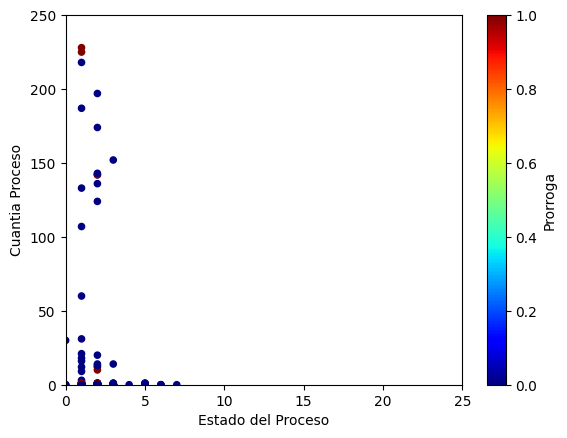

In [ ]:
# Gráfica del salario, años y hits
#plt.style.use('fivethirtyeight')
secop1.plot(kind='scatter', x='Estado del Proceso', y='Cuantia Proceso', c='Prorroga', colormap='jet', xlim=(0, 25), ylim=(0, 250))

## Definir las varibles del problema - Predictores y varible de respuesta

In [4]:
# Selección de variables predictoras para Prorroga
feature_cols = ['Orden Entidad',
                'Modalidad de Contratacion',
                'Estado del Proceso',
                #'Objeto a Contratar',
                'Municipio de Obtencion',
                'Cuantia Proceso',
                'Nombre Grupo',
                'Tipo Identifi del Contratista',
                'Dpto y Muni Contratista',
                'Anno Ini Ejec Contrato',
                'Mes Ini Ejec Contrato',
                'Plazo de Ejec del Contrato',
                'Rango de Ejec del Contrato',
                #'Prorroga',
                #'Tiempo Adiciones en Dias',
                #'Tiempo Adiciones en Meses',
                'Cuantia Contrato',
                #'Adicion',
                #'Valor Total de Adiciones',
                #'Valor Contrato con Adiciones',
                'Departamento Entidad'
                ]

# Separación de variables predictoras (X) y variable de interes (y)
secop1sample = secop1.sample(30000) # Se incia con un sample de 20k de los 135k registros
X = secop1sample[feature_cols]
y = (secop1sample['Adicion'])

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)
print('Train:', y_train.shape[0], '\ny_train:')
print(y_train.value_counts())
print('\nTest:', y_test.shape[0], '\ny_test:')
print(y_test.value_counts())

Train: 20100 
y_train:
0    18126
1     1974
Name: Adicion, dtype: int64

Test: 9900 
y_test:
0    8928
1     972
Name: Adicion, dtype: int64


In [5]:
# Funcion para mostrar los resultados
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay(conf_matrix).plot()
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, y_pred))

# Construir un árbol de decisiones

DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

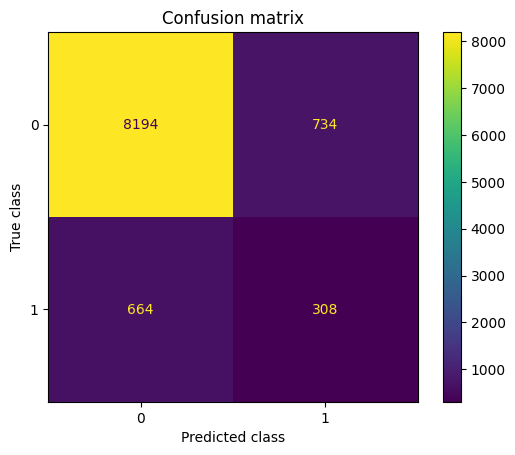

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8928
           1       0.30      0.32      0.31       972

    accuracy                           0.86      9900
   macro avg       0.61      0.62      0.61      9900
weighted avg       0.86      0.86      0.86      9900



In [6]:
# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Penalización para compensar

DecisionTreeClassifier(class_weight='balanced', random_state=1)


<Figure size 600x600 with 0 Axes>

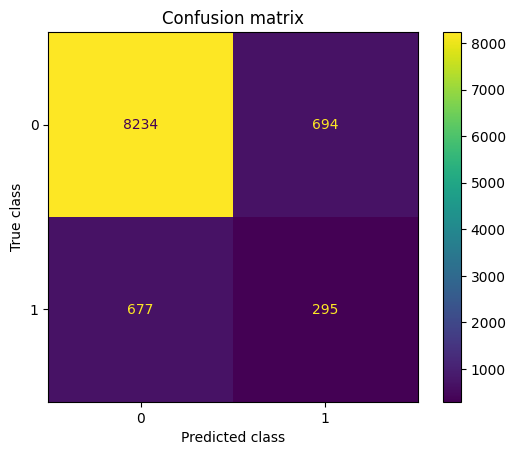

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8928
           1       0.30      0.30      0.30       972

    accuracy                           0.86      9900
   macro avg       0.61      0.61      0.61      9900
weighted avg       0.86      0.86      0.86      9900



In [7]:
# Arbol de decision
clf = DecisionTreeClassifier(random_state=1, class_weight='balanced')
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 1974, 1: 1974})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

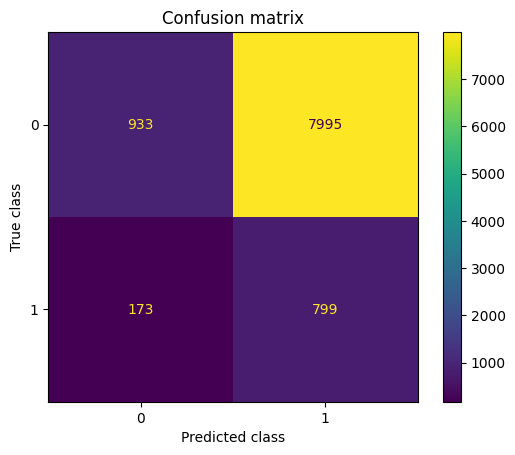

              precision    recall  f1-score   support

           0       0.84      0.10      0.19      8928
           1       0.09      0.82      0.16       972

    accuracy                           0.17      9900
   macro avg       0.47      0.46      0.17      9900
weighted avg       0.77      0.17      0.18      9900



In [8]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution labels after resampling Counter({0: 18126, 1: 18126})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

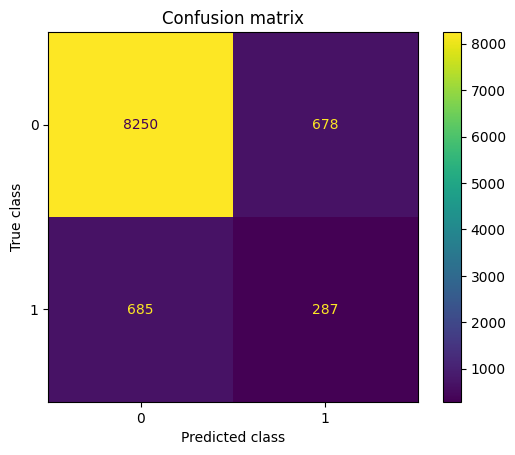

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8928
           1       0.30      0.30      0.30       972

    accuracy                           0.86      9900
   macro avg       0.61      0.61      0.61      9900
weighted avg       0.86      0.86      0.86      9900



In [9]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 16138, 1: 16138})
DecisionTreeClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

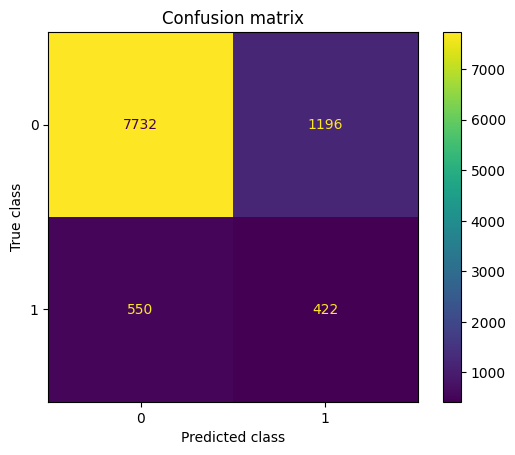

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      8928
           1       0.26      0.43      0.33       972

    accuracy                           0.82      9900
   macro avg       0.60      0.65      0.61      9900
weighted avg       0.87      0.82      0.84      9900



In [10]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = DecisionTreeClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

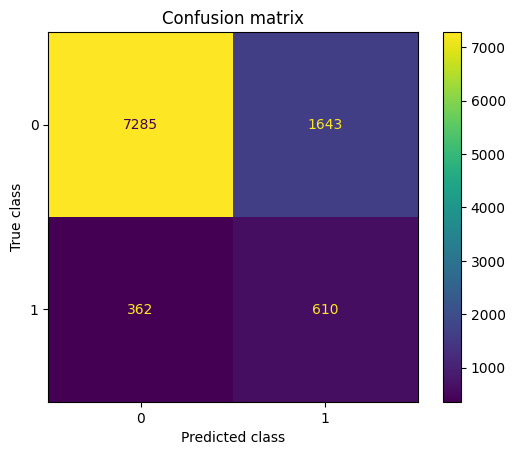

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8928
           1       0.27      0.63      0.38       972

    accuracy                           0.80      9900
   macro avg       0.61      0.72      0.63      9900
weighted avg       0.89      0.80      0.83      9900



In [11]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

In [ ]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

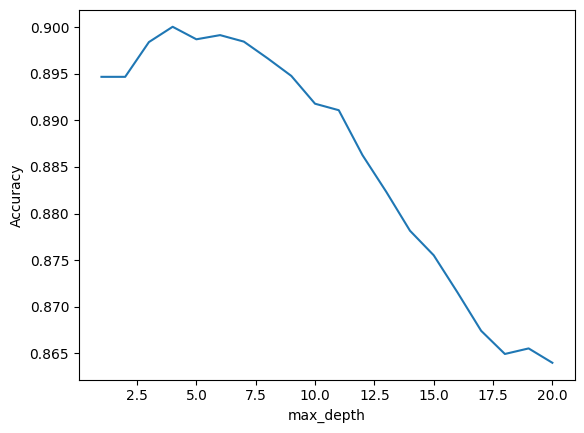

In [ ]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [ ]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.9000497512437811, 4)

DecisionTreeClassifier(max_depth=4, random_state=1)


<Figure size 600x600 with 0 Axes>

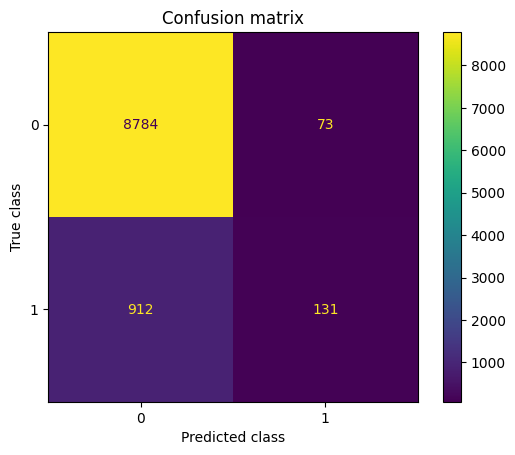

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8857
           1       0.64      0.13      0.21      1043

    accuracy                           0.90      9900
   macro avg       0.77      0.56      0.58      9900
weighted avg       0.88      0.90      0.87      9900



In [ ]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

<Figure size 600x600 with 0 Axes>

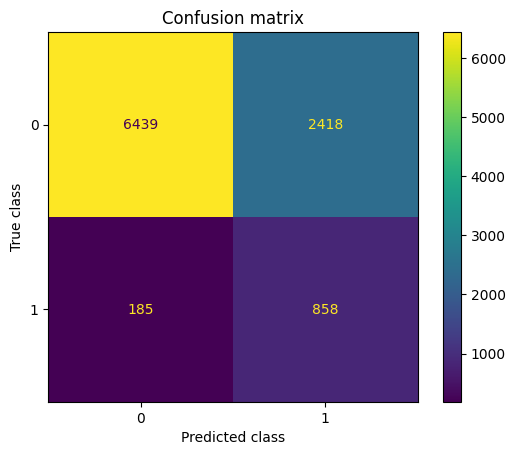

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      8857
           1       0.26      0.82      0.40      1043

    accuracy                           0.74      9900
   macro avg       0.62      0.77      0.61      9900
weighted avg       0.90      0.74      0.79      9900



In [ ]:
# Ensamble con balanceo de árboles
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4, random_state=1),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

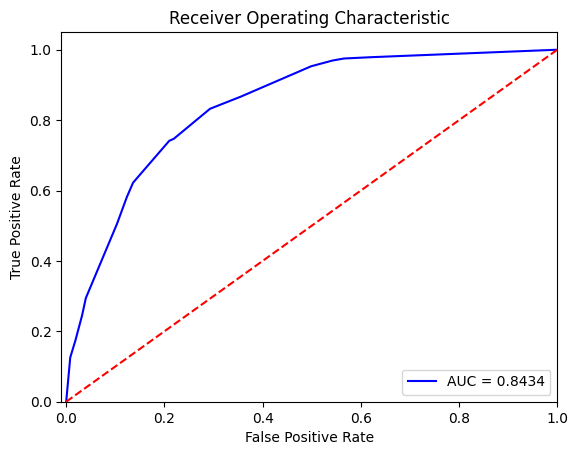

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

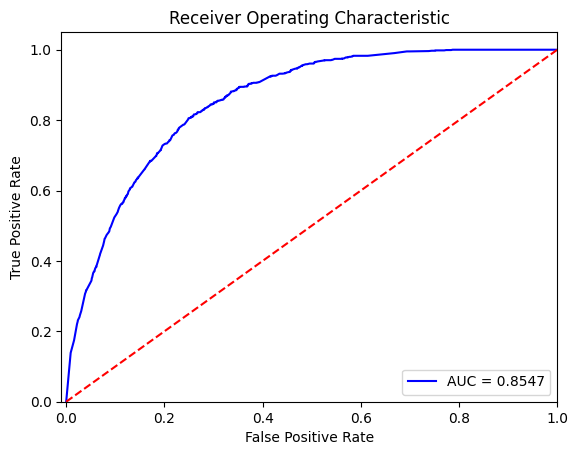

In [ ]:
# Curva ROC del modelo bbc
fpr, tpr, thresholds = roc_curve(y_test, bbc.predict_proba(X_test)[:,1], pos_label=bbc.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Importancia de las variables

In [ ]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
0,Orden Entidad,0.000000
3,Municipio de Obtencion,0.000000
5,Nombre Grupo,0.000000
6,Tipo Identifi del Contratista,0.000000
8,Anno Ini Ejec Contrato,0.000000
9,Mes Ini Ejec Contrato,0.000000
13,Departamento Entidad,0.000000
10,Plazo de Ejec del Contrato,0.003155
11,Rango de Ejec del Contrato,0.004565
1,Modalidad de Contratacion,0.011319


In [ ]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.900000
std       0.001981
min       0.896667
25%       0.899250
50%       0.900167
75%       0.901417
max       0.902333
dtype: float64

# Construir un Random Forest

RandomForestClassifier()


<Figure size 600x600 with 0 Axes>

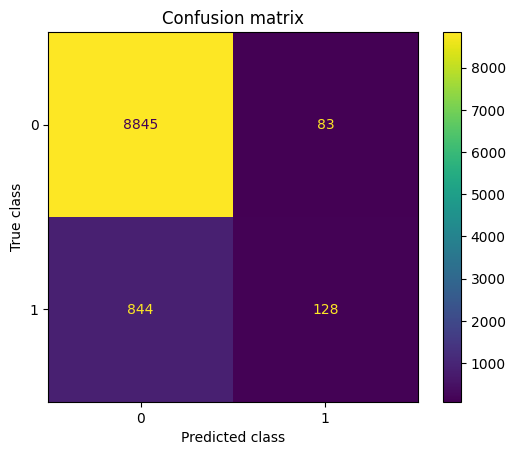

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8928
           1       0.61      0.13      0.22       972

    accuracy                           0.91      9900
   macro avg       0.76      0.56      0.58      9900
weighted avg       0.88      0.91      0.88      9900



In [12]:
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

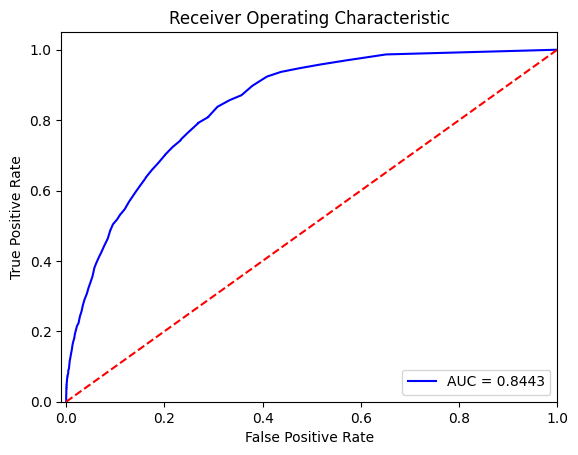

In [13]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
pd.Series(cross_val_score(clf, X_train, y_train, cv=10)).describe()

count    10.000000
mean      0.908706
std       0.003078
min       0.905970
25%       0.906468
50%       0.907711
75%       0.909577
max       0.915423
dtype: float64

## Estrategia: Penalización para compensar

RandomForestClassifier(class_weight='balanced', random_state=1)


<Figure size 600x600 with 0 Axes>

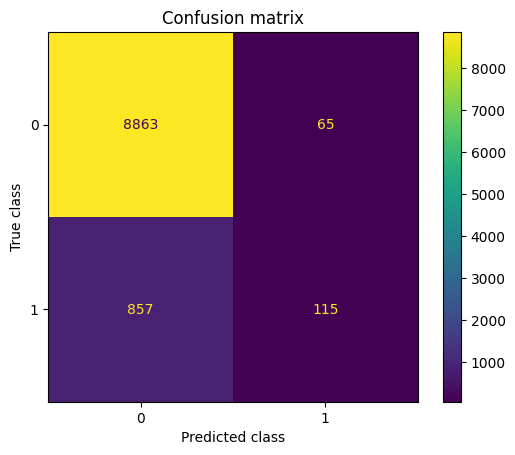

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8928
           1       0.64      0.12      0.20       972

    accuracy                           0.91      9900
   macro avg       0.78      0.56      0.58      9900
weighted avg       0.89      0.91      0.88      9900



In [14]:
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier(random_state=1, class_weight='balanced')
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

## Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 1974, 1: 1974})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

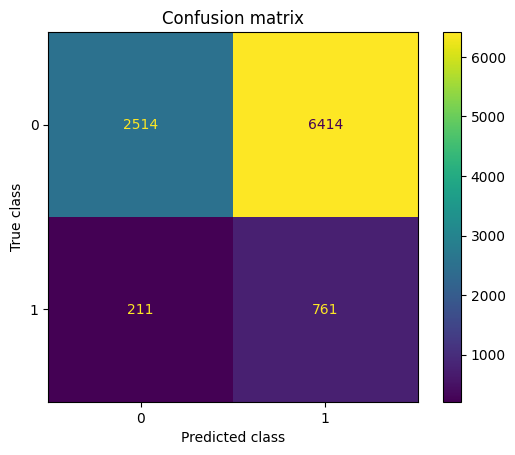

              precision    recall  f1-score   support

           0       0.92      0.28      0.43      8928
           1       0.11      0.78      0.19       972

    accuracy                           0.33      9900
   macro avg       0.51      0.53      0.31      9900
weighted avg       0.84      0.33      0.41      9900



In [15]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution labels after resampling Counter({0: 18126, 1: 18126})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

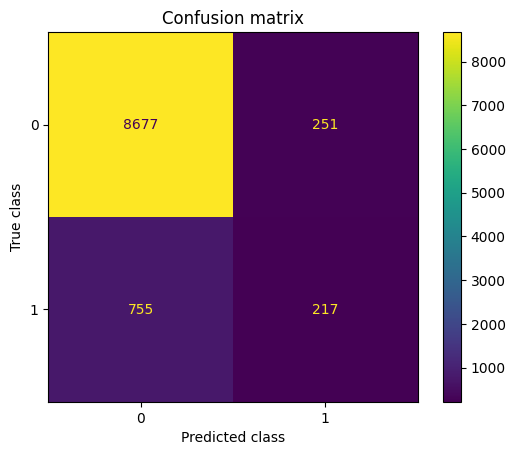

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8928
           1       0.46      0.22      0.30       972

    accuracy                           0.90      9900
   macro avg       0.69      0.60      0.62      9900
weighted avg       0.88      0.90      0.88      9900



In [16]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 16139, 1: 16139})
RandomForestClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

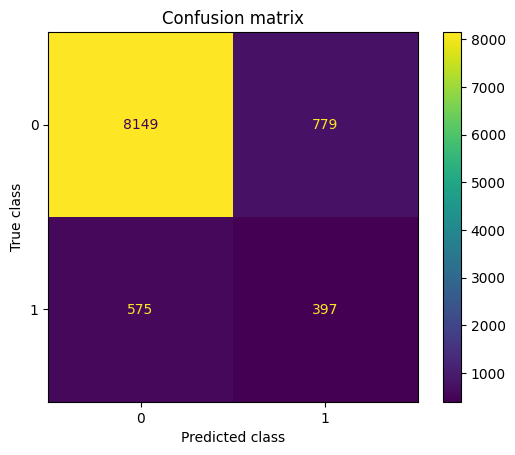

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      8928
           1       0.34      0.41      0.37       972

    accuracy                           0.86      9900
   macro avg       0.64      0.66      0.65      9900
weighted avg       0.88      0.86      0.87      9900



In [17]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = RandomForestClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

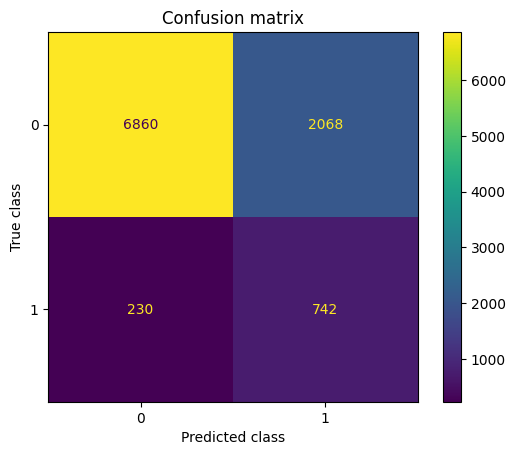

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      8928
           1       0.26      0.76      0.39       972

    accuracy                           0.77      9900
   macro avg       0.62      0.77      0.62      9900
weighted avg       0.90      0.77      0.81      9900



In [18]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=RandomForestClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

## Calibración de parámetros

### Calibración de n_estimators

n_estimators es la cantidad de árboles a contruir dentro del bosque aleatorio.

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    print(estimator)
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


Text(0, 0.5, 'Accuracy')

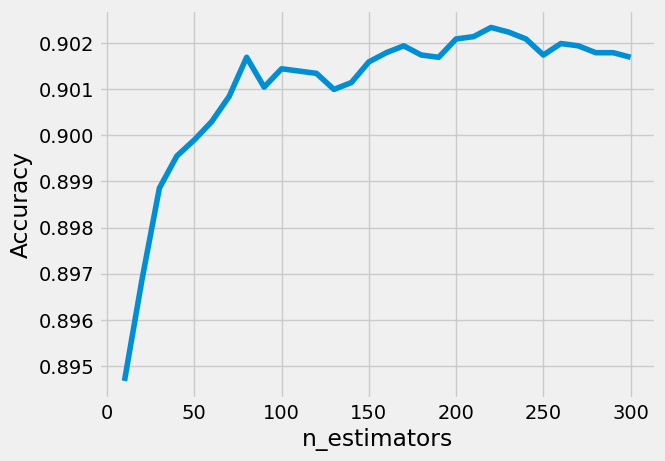

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

### Calibracióm max_features

max_features es el número de variables que se deben considerar en cada árbol.

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    print(feature)
    clf = RandomForestClassifier(n_estimators=220, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0, 0.5, 'Accuracy')

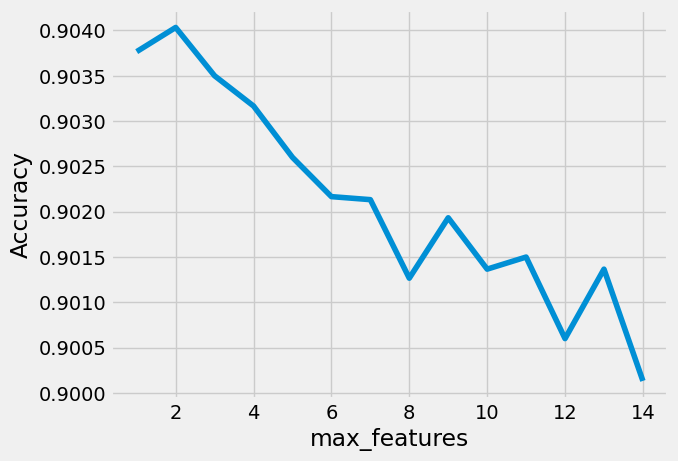

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Implementación de un Random Forest con los mejores parámetros

RandomForestClassifier(max_features=2, n_estimators=120, n_jobs=-1,
                       random_state=1)


<Figure size 600x600 with 0 Axes>

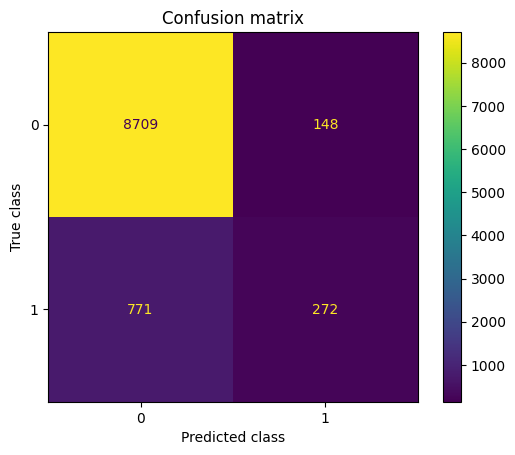

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8857
           1       0.65      0.26      0.37      1043

    accuracy                           0.91      9900
   macro avg       0.78      0.62      0.66      9900
weighted avg       0.89      0.91      0.89      9900



In [ ]:
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
clf = RandomForestClassifier(n_estimators=120, max_features=2, random_state=1, n_jobs=-1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

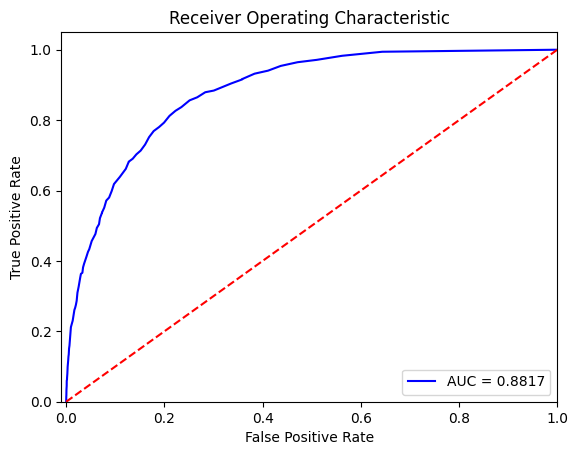

In [ ]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
11,Rango de Ejec del Contrato,0.022676
5,Nombre Grupo,0.022685
6,Tipo Identifi del Contratista,0.030535
2,Estado del Proceso,0.031372
1,Modalidad de Contratacion,0.041053
8,Anno Ini Ejec Contrato,0.041782
0,Orden Entidad,0.054617
13,Departamento Entidad,0.066534
9,Mes Ini Ejec Contrato,0.075833
7,Dpto y Muni Contratista,0.081199


<Figure size 600x600 with 0 Axes>

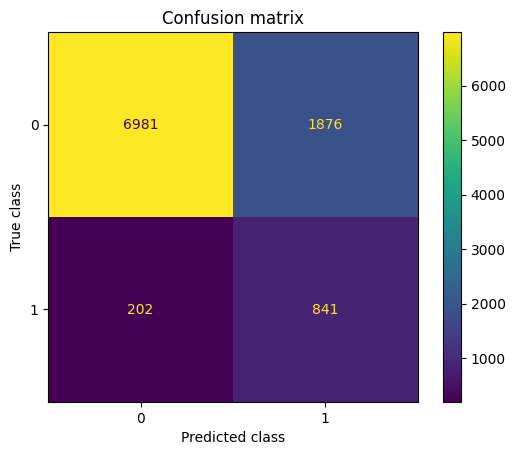

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      8857
           1       0.31      0.81      0.45      1043

    accuracy                           0.79      9900
   macro avg       0.64      0.80      0.66      9900
weighted avg       0.90      0.79      0.83      9900



In [ ]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=RandomForestClassifier(n_estimators=120, max_features=2, random_state=1, n_jobs=-1),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

# Construir un AdaBoost

AdaBoostClassifier()


<Figure size 600x600 with 0 Axes>

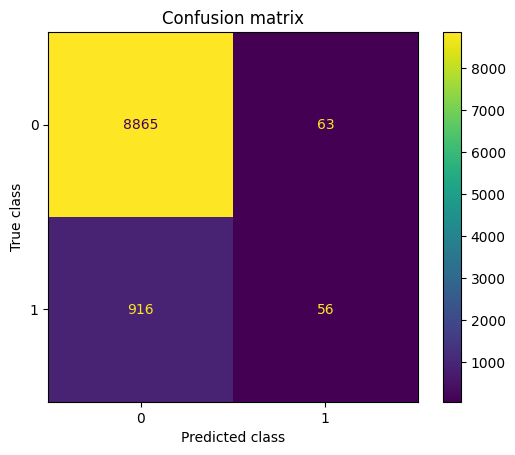

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8928
           1       0.47      0.06      0.10       972

    accuracy                           0.90      9900
   macro avg       0.69      0.53      0.53      9900
weighted avg       0.86      0.90      0.86      9900



In [19]:
# Importación y definición de modelo AdaBoostClassifier
clf = AdaBoostClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mostrar_resultados(y_test, y_pred)

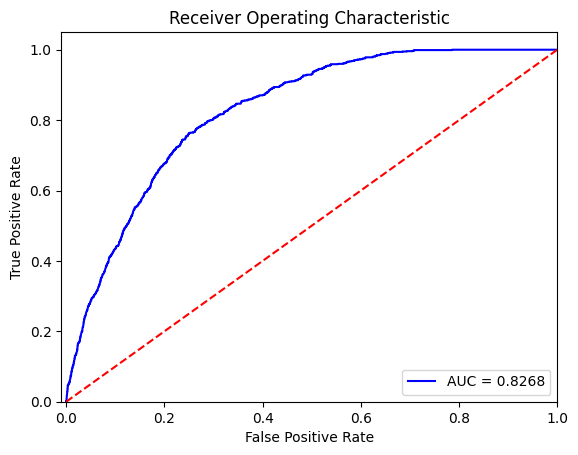

In [20]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 1974, 1: 1974})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

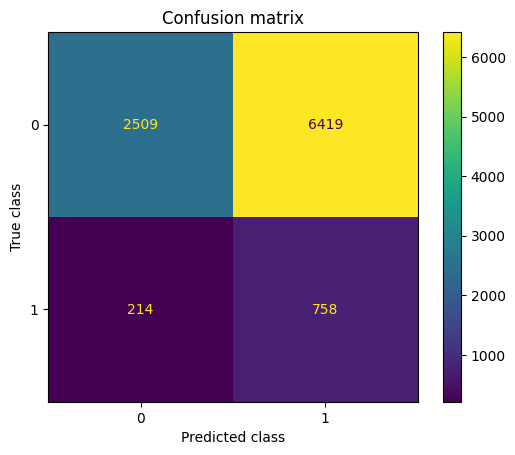

              precision    recall  f1-score   support

           0       0.92      0.28      0.43      8928
           1       0.11      0.78      0.19       972

    accuracy                           0.33      9900
   macro avg       0.51      0.53      0.31      9900
weighted avg       0.84      0.33      0.41      9900



In [21]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution labels after resampling Counter({0: 18126, 1: 18126})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

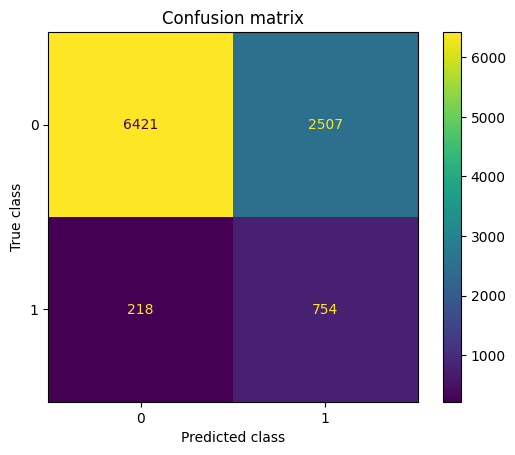

              precision    recall  f1-score   support

           0       0.97      0.72      0.82      8928
           1       0.23      0.78      0.36       972

    accuracy                           0.72      9900
   macro avg       0.60      0.75      0.59      9900
weighted avg       0.89      0.72      0.78      9900



In [22]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 16220, 1: 16220})
AdaBoostClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

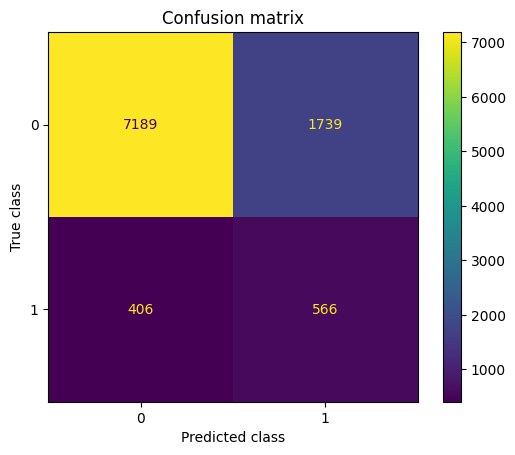

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      8928
           1       0.25      0.58      0.35       972

    accuracy                           0.78      9900
   macro avg       0.60      0.69      0.61      9900
weighted avg       0.88      0.78      0.82      9900



In [23]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = AdaBoostClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

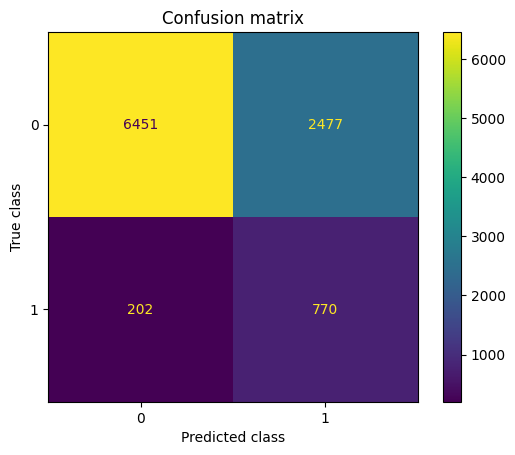

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      8928
           1       0.24      0.79      0.37       972

    accuracy                           0.73      9900
   macro avg       0.60      0.76      0.60      9900
weighted avg       0.90      0.73      0.78      9900



In [24]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=AdaBoostClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

# Construir un Gradient Boosting

GradientBoostingClassifier()


<Figure size 600x600 with 0 Axes>

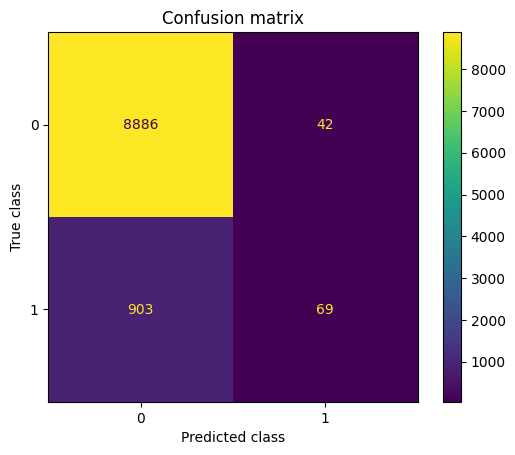

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      8928
           1       0.62      0.07      0.13       972

    accuracy                           0.90      9900
   macro avg       0.76      0.53      0.54      9900
weighted avg       0.88      0.90      0.87      9900



In [25]:
# Importación y definición de modelo GradientBoostingClassifier
clf = GradientBoostingClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo GradientBoostingClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)
mostrar_resultados(y_test, y_pred)

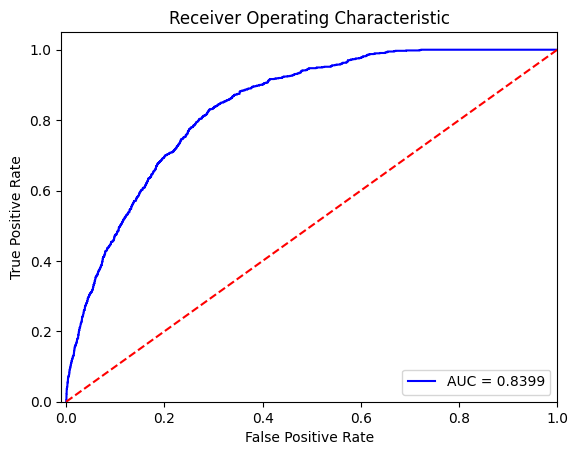

In [26]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 1974, 1: 1974})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

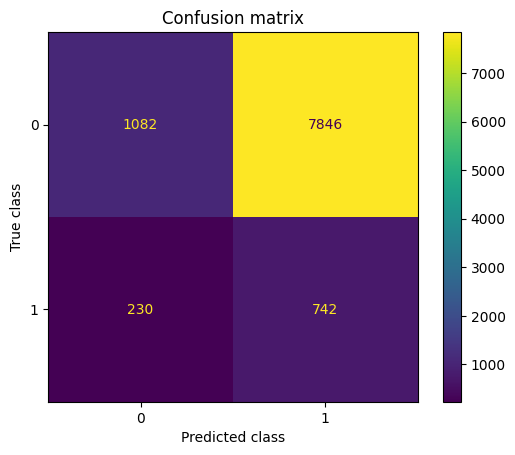

              precision    recall  f1-score   support

           0       0.82      0.12      0.21      8928
           1       0.09      0.76      0.16       972

    accuracy                           0.18      9900
   macro avg       0.46      0.44      0.18      9900
weighted avg       0.75      0.18      0.21      9900



In [27]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution labels after resampling Counter({0: 18126, 1: 18126})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

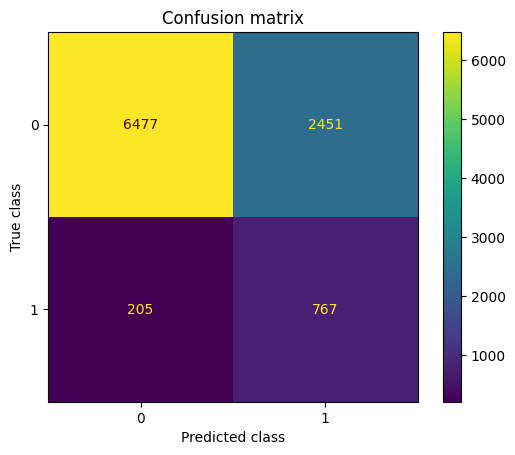

              precision    recall  f1-score   support

           0       0.97      0.73      0.83      8928
           1       0.24      0.79      0.37       972

    accuracy                           0.73      9900
   macro avg       0.60      0.76      0.60      9900
weighted avg       0.90      0.73      0.78      9900



In [28]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 16145, 1: 16145})
GradientBoostingClassifier(random_state=1)


<Figure size 600x600 with 0 Axes>

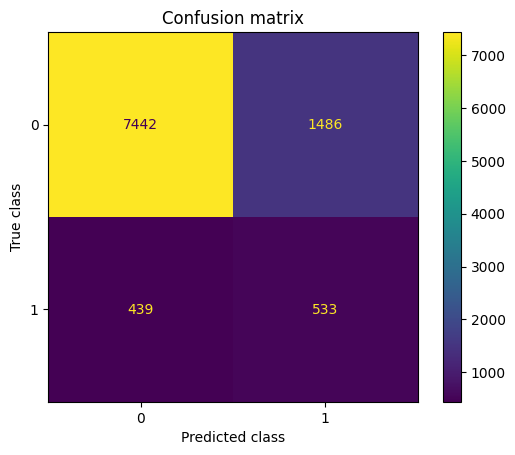

              precision    recall  f1-score   support

           0       0.94      0.83      0.89      8928
           1       0.26      0.55      0.36       972

    accuracy                           0.81      9900
   macro avg       0.60      0.69      0.62      9900
weighted avg       0.88      0.81      0.83      9900



In [29]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = GradientBoostingClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

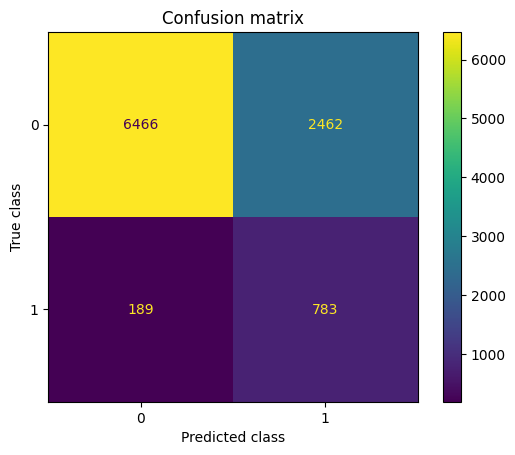

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      8928
           1       0.24      0.81      0.37       972

    accuracy                           0.73      9900
   macro avg       0.61      0.76      0.60      9900
weighted avg       0.90      0.73      0.78      9900



In [30]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=GradientBoostingClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)

# Construir un Gradient XGBoost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


<Figure size 600x600 with 0 Axes>

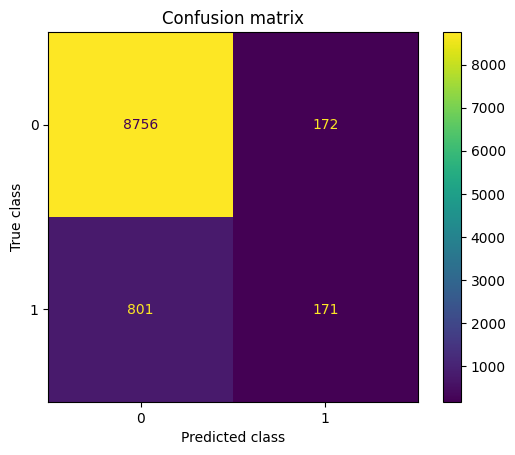

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8928
           1       0.50      0.18      0.26       972

    accuracy                           0.90      9900
   macro avg       0.71      0.58      0.60      9900
weighted avg       0.88      0.90      0.88      9900



In [31]:
# Importación y definición de modelo XGBClassifier
clf = XGBClassifier()
print(clf)

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)
mostrar_resultados(y_test, y_pred)

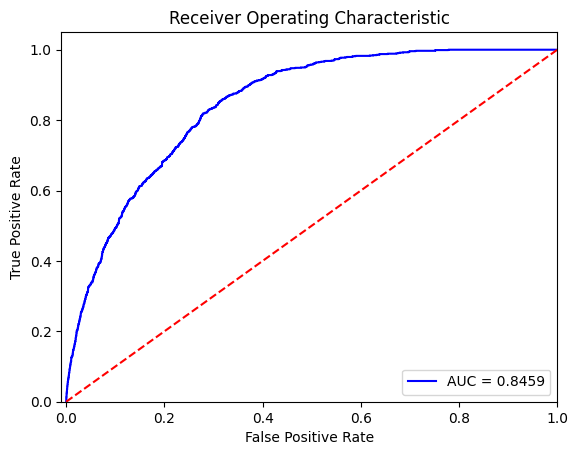

In [32]:
# Curva ROC del modelo
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=clf.classes_[1])
AUC=auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 1974, 1: 1974})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

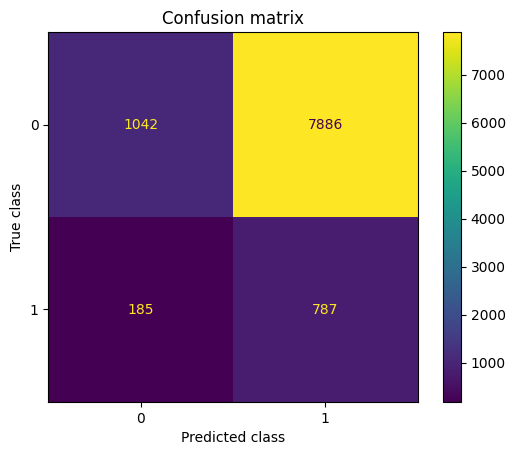

              precision    recall  f1-score   support

           0       0.85      0.12      0.21      8928
           1       0.09      0.81      0.16       972

    accuracy                           0.18      9900
   macro avg       0.47      0.46      0.18      9900
weighted avg       0.77      0.18      0.20      9900



In [33]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution labels after resampling Counter({0: 18126, 1: 18126})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

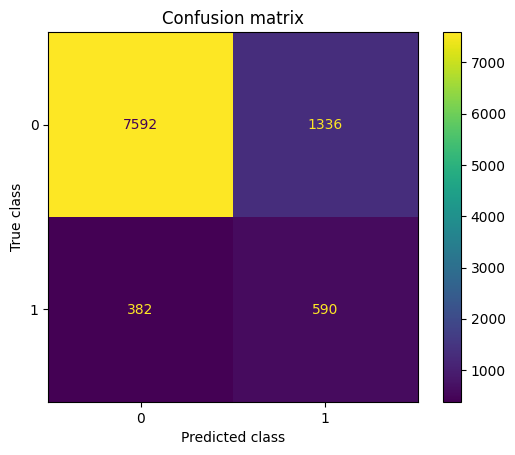

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      8928
           1       0.31      0.61      0.41       972

    accuracy                           0.83      9900
   macro avg       0.63      0.73      0.65      9900
weighted avg       0.89      0.83      0.85      9900



In [34]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 18126, 1: 1974})
Distribution after resampling Counter({0: 16197, 1: 16197})
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


<Figure size 600x600 with 0 Axes>

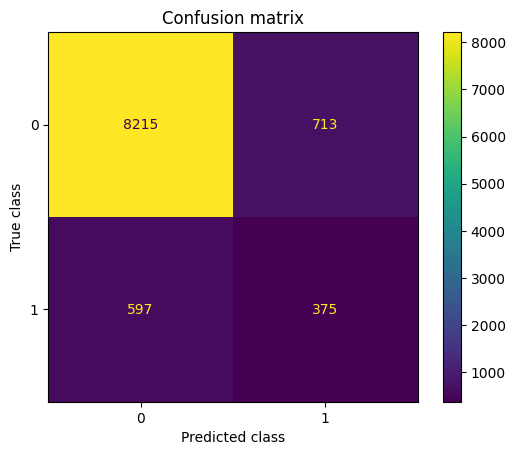

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      8928
           1       0.34      0.39      0.36       972

    accuracy                           0.87      9900
   macro avg       0.64      0.65      0.65      9900
weighted avg       0.87      0.87      0.87      9900



In [35]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

# Arbol de decision 
clf = XGBClassifier(random_state=1)
print(clf)

# Entrenamiento (fit) y desempeño del modelo AdaBoostClassifier
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

# Matriz de confusión del modelo y metricas
mostrar_resultados(y_test, y_pred)

## Estrategia: Ensamble de Modelos con Balanceo

<Figure size 600x600 with 0 Axes>

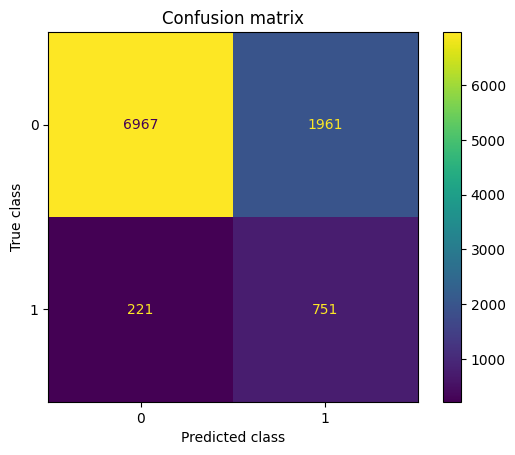

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      8928
           1       0.28      0.77      0.41       972

    accuracy                           0.78      9900
   macro avg       0.62      0.78      0.64      9900
weighted avg       0.90      0.78      0.82      9900



In [36]:
# Ensamble con balanceo de random forest
bbc = BalancedBaggingClassifier(estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
 
#Train the classifier.
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)